# Homework 1 - Emmanouil Chatzakis, 353068

In this homework, we're going to build a neural network without using deep learning packages.

Specifically, we're going to build a neural network that annotate cells to cell types in the Pancreas tissue. To do so, we'll need a few building blocks:
- Fully-connected layer, $f(X)=X \cdot W + \vec{b}$
- Nonlinearity layer (ReLU in this homework)
- Loss function (Cross-entropy in this homework)
- Backprop algorithm - a stochastic gradient descent with backpropageted gradients

Reference: 
- https://github.com/yandexdataschool/Practical_DL/tree/fall23
- https://github.com/theislab/scarches-reproducibility

In [ ]:
import numpy as np

np.random.seed(0)

## 0. Create the Parent Class 'Layer' (0 pt)

As we learned in the lecture, we need layers that can do both forward pass and backward pass. Here we define the parent class of all layers.

In [24]:
class Layer:

    """
    Each layer performs two things:
    1. Forward pass: Process input to get output: output = layer.forward(input)
    2. Backward pass: Back-propagate gradients through itself: grad_input = layer.backward(input, grad_output)

    The layers that contain learnable parameters also update their parameters during layer.backward.
    """

    def __init__(self):
        """
        Initialize layer parameters.
        """

        # Here we use a dummy layer that does nothing.
        pass

    def forward(self, input):
        """
        Takes input data of shape [batch, input_dims], returns output data [batch, output_dims]
        """

        # Here we use a dummy layer that returns the input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer.

        We need to apply the chain rule to compute the gradients of the input x:
        d loss / d x  = (d loss / d layer) * (d layer / d x)

        Grad_output provides us d loss / d layer, so we only need to multiply it by d layer / d x.

        Note that if the layer has trainable parameters, we also need to update them using d loss / d layer.
        """

        # The gradient of a dummy layer is grad_output
        return grad_output

## 1. Build layers

We will shortly introduce our dataset's structure in this section, and it should be enough to complete the functions in this section. However, if you find knowing the dataset structure is super helpful to implement the functions of this section, *you can jump to Section 2* and check the dataset structure before going through this section.

### 1.1. Nonlinearity layer - ReLU (1 pt) 

We start from the simplest layer: nonlinearity layer. It simply applies a nonlinearity to each element of your network and it contains no trainable parameter.

Here we implement ReLU. 

Check this link to review ReLU if needed: https://www.v7labs.com/blog/neural-networks-activation-functions

In [25]:
class ReLU(Layer):
    def __init__(self):
        """
        ReLU layer applies elementwise rectified linear to the elements in the inputs.
        There is nothing to initialize in this simple implementation.
        """

        pass

    def forward(self, input):
        """
        Apply elementwise ReLU to the input
        """

        # ReLU keeps only the positive elements and discards the negative elements
        output = np.maximum(0, input)

        return output

    def backward(self, input, grad_output):
        """
        Compute the gradient of loss.
        """

        d_input = (
            input > 0
        )  # 1 if input > 0, 0 otherwise (gradient of f'(x) = 1 for x > 0, 0 otherwise)
        grad_input = d_input * grad_output

        return grad_input

### 1.2. Fully-connected Layer (2 pts)

After implementing the simplest layer, we come to a more complicated one: a fully-connected layer. Unlike a nonlinearity layer, a fully-connected layer has trainable parameters.

A fully-connected layer applies an affine transformation. It can be described as: 
$$f(X)= X \cdot W + \vec b ,$$

where
* X is the input of shape [batch_size, input_dims],
* W is a weight matrix [input_dims, output_dims],
* and b is a vector of outputs_dims biases.

W and b are
* initialized when the layer is created,
* and updated each time backward is called.

In [26]:
class Fully_connected(Layer):
    def __init__(self, input_dims, output_dims, learning_rate=0.1):
        """
        Fully_connected layer: f(x) = <x*W> + b
        We initialize W, b, and learning rate to update W and b.
        """
        # Here we use normal initialization for W and zero initialization for b

        # Using normal distribution to initialize weights
        self.scale_factor = 0.01
        self.weights = np.random.normal(
            scale=self.scale_factor, size=(input_dims, output_dims)
        )
        # Use this for random init:
        # self.weights = np.random.randn(input_dims, output_dims) * self.scale_factor

        self.biases = np.zeros((1, output_dims))
        self.learning_rate = learning_rate

    def forward(self, input):
        """
        Perform f(x) = <x*W> + b .

        input shape: [batch, input_dims]
        output shape: [batch, output_dims]
        """

        output = np.dot(input, self.weights) + self.biases

        return output

    def backward(self, input, grad_output):
        # Calculate  d loss / d x  = (d loss / d layer) * (d layer / d x)

        # Calculate the grad_input to back propagate:
        grad_input = np.dot(grad_output, self.weights.T)

        # Here we perform a stochastic gradient descent (SGD) step: x = x - learning_rate * gradient_of_x.
        # Update parameter W
        self.weights = self.weights - self.learning_rate * np.dot(input.T, grad_output)

        # Update parameter b
        self.biases = self.biases - self.learning_rate * np.sum(
            grad_output, axis=0, keepdims=True
        )

        return grad_input

In [27]:
# Very basic testing to ensure that syntax is correct.
batch_size = 10

X = np.random.randn(batch_size, 3)
print("X Shape:", X.shape)

print()

layer = Fully_connected(3, 4)
print("W Shape:", layer.weights.shape)
print("b Shape:", layer.biases.shape)

print()

output = layer.forward(X)
print("Output Shape:", output.shape)
RELU_output = ReLU().forward(output)
print("RELU Output Shape:", RELU_output.shape)

print()
print("Output:\n", output)
print("\nRELU Output:\n", RELU_output)

X Shape: (10, 3)

W Shape: (3, 4)
b Shape: (1, 4)

Output Shape: (10, 4)
RELU Output Shape: (10, 4)

Output:
 [[-0.00244976  0.00433787 -0.02100049 -0.04402913]
 [ 0.00076     0.01434846  0.01332934 -0.00805487]
 [ 0.00239852  0.00366827 -0.00921458 -0.01917348]
 [-0.00549772 -0.00261837 -0.01712191 -0.02705211]
 [-0.00096332  0.00172639 -0.00991357 -0.01991455]
 [-0.00388643  0.00421801  0.0175704   0.01426838]
 [ 0.01334501  0.00756629  0.01348222  0.0197822 ]
 [ 0.00087989  0.00606686  0.01261434  0.00798583]
 [ 0.00839961  0.00617115 -0.03852329 -0.063096  ]
 [-0.01131398 -0.00275329  0.00511243  0.0012724 ]]

RELU Output:
 [[0.         0.00433787 0.         0.        ]
 [0.00076    0.01434846 0.01332934 0.        ]
 [0.00239852 0.00366827 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.00172639 0.         0.        ]
 [0.         0.00421801 0.0175704  0.01426838]
 [0.01334501 0.00756629 0.01348222 0.0197822 ]
 [0.00087989 0.00606686 0.01261434 

### 1.3. The loss function - softmax cross-entropy (2 pts)

Our model outputs the logits. Since we want to predict probabilities, it would be logical for us to apply softmax nonlinearity to our output logits and compute loss with predicted probabilities.

If you are not familiar with softmax or cross-entropy loss, you can check:
- Softmax: https://en.wikipedia.org/wiki/Softmax_function
- Cross-entropy loss: https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy


(We encourage you to first write down the expression for cross-entropy as a function of softmax logits. You can then try to rewrite it into a more concise form.)

In [28]:
def batch_softmax(logits):
    """
    Compute softmax activations.
    logits shape: [batch_size, n_classes]
    output shape: [batch_size, n_classes]
    """

    expon_logits = np.exp(logits)
    softmax_logists = expon_logits / np.sum(expon_logits, axis=1, keepdims=True)

    return softmax_logists


def toOneHot(true_index, num_classes):
    """
    Convert class index to one hot vector.
    true_index shape: [batch_size, 1]
    """

    one_hot_batch = np.zeros((true_index.shape[0], num_classes))
    one_hot_batch[np.arange(true_index.shape[0]), true_index] = 1

    return one_hot_batch

In [29]:
batch_size = 5
classes = 4

synthetic_logits = np.random.randn(batch_size, classes)
print("Synthetic Logits Shape:", synthetic_logits.shape)

softmax_logits = batch_softmax(synthetic_logits)
print("Softmax Logits Shape:", softmax_logits.shape)

print()

print("Logits:\n", synthetic_logits)
print()
print("Softmax Logits:\n", softmax_logits)

Synthetic Logits Shape: (5, 4)
Softmax Logits Shape: (5, 4)

Logits:
 [[-1.70627019  1.9507754  -0.50965218 -0.4380743 ]
 [-1.25279536  0.77749036 -1.61389785 -0.21274028]
 [-0.89546656  0.3869025  -0.51080514 -1.18063218]
 [-0.02818223  0.42833187  0.06651722  0.3024719 ]
 [-0.63432209 -0.36274117 -0.67246045 -0.35955316]]

Softmax Logits:
 [[0.0214546  0.83129512 0.0709913  0.07625898]
 [0.08235507 0.62723784 0.05739388 0.23301321]
 [0.14649488 0.52813903 0.2152181  0.110148  ]
 [0.19724767 0.31136761 0.21683997 0.27454475]
 [0.2178249  0.28579434 0.20967384 0.28670691]]


In [30]:
true_labels = np.array([0, 0, 2, 3])
classes = 5
print("True Labels Shape:", true_labels.shape)

one_hot_true_labels = toOneHot(true_labels, classes)
print("One Hot Labels:\n", one_hot_true_labels)
print("One Hot Labels Shape:", one_hot_true_labels.shape)

True Labels Shape: (4,)
One Hot Labels:
 [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]
One Hot Labels Shape: (4, 5)


In [31]:
def softmax_crossentropy_with_logits(logits, reference_answers):
    """
    Compute cross-entropy loss for each sample from output logits [batch,n_classes] and reference_answers [batch].
    Note that the reference_answers are not one-hot labels. Instead, they are the index of the categories, e.g., 2 instead of [0,0,1].
    The output (xentropy) shape should be [batch,1] or [batch].
    """

    # Get the cross-entropy loss based on output logits and reference_answers
    # Logits is the raw output without softmax. So, it is better to first derive and get the simplest form of the softmax cross-entropy before implementation.

    softmax_logits = batch_softmax(logits)
    reference_answers_one_hot = toOneHot(reference_answers, logits.shape[1])

    # Element-wise multiplication
    xentropy = -np.sum(
        reference_answers_one_hot * np.log(softmax_logits), axis=1, keepdims=True
    )

    return xentropy


def grad_softmax_crossentropy_with_logits(logits, reference_answers):
    """
    Compute cross-entropy gradient from output logits [batch,n_classes] and reference_answers [batch].
    Note that the reference_answers are not one-hot labels. Instead, they are the index of the categories, e.g., 2 instead of [0,0,1].
    """

    # Get the cross-entropy gradient based on output logits and reference_answers
    # Hint: Same as before, it is better to first derive and get the simplest form of the softmax cross-entropy gradient before implementation.
    batch_size, n_classes = logits.shape
    y_one_hot = toOneHot(reference_answers, n_classes)

    softmax_logits = batch_softmax(logits)
    grad_input = (-y_one_hot + softmax_logits) / batch_size

    return grad_input

In [32]:
# Do some testing here to ensure that the syntax is correct.
batch_size = 5
classes = 4

synthetic_logits = np.random.randn(batch_size, classes)
print("Logits shape:", synthetic_logits.shape)

reference_answers = np.array([0, 0, 2, 3, 1])
print("Reference Answers (oneHot):\n", toOneHot(reference_answers, classes))
print()
print("\n--- Testing cross-entropy loss ---")

loss = softmax_crossentropy_with_logits(synthetic_logits, reference_answers)
print("Loss shape:", loss.shape)

print()

print("Logits:\n", synthetic_logits)
print()
print("log(softmax):\n", np.log(batch_softmax(synthetic_logits)))
print()
print("Loss (per sample):\n", loss)

print("\n--- Testing cross-entropy loss gradient ---")

# Test also the grads!
gradient = grad_softmax_crossentropy_with_logits(synthetic_logits, reference_answers)
print("Gradient shape:", gradient.shape)
print("Gradient:\n", gradient)

Logits shape: (5, 4)
Reference Answers (oneHot):
 [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


--- Testing cross-entropy loss ---
Loss shape: (5, 1)

Logits:
 [[-0.81314628 -1.7262826   0.17742614 -0.40178094]
 [-1.63019835  0.46278226 -0.90729836  0.0519454 ]
 [ 0.72909056  0.12898291  1.13940068 -1.23482582]
 [ 0.40234164 -0.68481009 -0.87079715 -0.57884966]
 [-0.31155253  0.05616534 -1.16514984  0.90082649]]

log(softmax):
 [[-1.72328713 -2.63642345 -0.7327147  -1.31192178]
 [-2.80617577 -0.71319517 -2.08327579 -1.12403203]
 [-1.16200814 -1.7621158  -0.75169802 -3.12592453]
 [-0.68913478 -1.77628651 -1.96227357 -1.67032609]
 [-1.82966309 -1.46194522 -2.6832604  -0.61728407]]

Loss (per sample):
 [[1.72328713]
 [2.80617577]
 [0.75169802]
 [1.67032609]
 [1.46194522]]

--- Testing cross-entropy loss gradient ---
Gradient shape: (5, 4)
Gradient:
 [[-0.1643043   0.01432339  0.09612051  0.0538604 ]
 [-0.18791287  0.09801516  0.02490433  0.06499337]
 [ 0.06

### 1.4. Network and Forward pass (1 pts)

First, we define network as a list of layers, each applied on top of previous one.

In [33]:
network = []
network.append(Fully_connected(1000, 256))
network.append(ReLU())
network.append(Fully_connected(256, 64))
network.append(ReLU())
network.append(Fully_connected(64, 8))

Here, we implement the forward pass.

In [34]:
def forward(network, X):
    """
    Compute the output of all network layers by applying them sequentially.
    Note that we should return a list of outputs for each layer since we need them for backwrad pass.
    """

    outputs = []
    input = X

    # Using network to get a list of outputs for each layer
    for layer in network:
        input = layer.forward(input)
        outputs.append(input)

    return outputs


def predict(network, X):
    """
    Use network to predict the result for each sample. Since we are doing classification, the result should be the index of the most likely class.
    """

    # ToDo: using network to get the final output of the model
    outputs = forward(network, X)
    final_layer_output = outputs[-1]

    prediction_probabilities = batch_softmax(final_layer_output)
    prediction = np.argmax(prediction_probabilities, axis=1)

    return prediction

In [35]:
# Some Testing
batch_size = 5
X_features = 1000
num_classes = 8  # Possible indices: 0,1,2,3,4,5,6,7

X = np.random.randn(batch_size, X_features)
print("X Shape:", X.shape)

print()

print("Input shape:", X.shape)
network_outputs = forward(network, X)
for i, out in enumerate(network_outputs):
    print("Layer {} output shape: {}".format(i, out.shape))

batch_predictions = predict(network, X)
print("Batch Predictions Shape:", batch_predictions.shape)
print("Batch Predictions:\n", batch_predictions)

X Shape: (5, 1000)

Input shape: (5, 1000)
Layer 0 output shape: (5, 256)
Layer 1 output shape: (5, 256)
Layer 2 output shape: (5, 64)
Layer 3 output shape: (5, 64)
Layer 4 output shape: (5, 8)
Batch Predictions Shape: (5,)
Batch Predictions:
 [1 2 5 4 1]


### 1.5. Train and Backprop (2 pts)

We implement the training function here. The function takes a network, network input X, and ground truth y as the inputs.
When calling this function, we want to have a forward pass and a backward pass.

In [36]:
def train(network, X, y):
    """
    Train your network on a given batch of X and y only once.
    Here are the steps to train once:
    1. Run forward to get all layer outputs.
    2. Estimate loss and loss_grad.
    3. Run layer.backward going from last layer to first.

    Note that after you called backward for all layers, the layers with trainable parameters should have already updated.
    """

    # Run forward to get outputs of all layers.
    layer_outputs = forward(network, X)

    # Since we need the layer input for backward pass, here we get a list of layer input.
    # layer_input[i] is an input for network[i].
    layer_inputs = []
    layer_inputs.append(X)
    for curr_out_index in range(len(layer_outputs) - 1):
        curr_input = layer_outputs[curr_out_index]
        layer_inputs.append(curr_input)

    logits = layer_outputs[-1]

    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits, y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits, y)

    # Propagate gradients through network layers using .backward
    # Start from last layer and move to earlier layers
    for i in range(len(network) - 1, -1, -1):
        loss_grad = network[i].backward(layer_inputs[i], loss_grad)

    return np.mean(loss)

## 2. Test your network (2 pt)

In this homework, we use a single-cell dataset: Pancreas Dataset. Our task is to classify cells to cell types based on the gene expression information. There are 8 different cell types. Cells are samples, genes are features, and cell types are classes.

You need to load the data from '.csv' and implement a simple dataloader. (If you do not remember why we need a dataloader, you can check Exercise 1.)

In [37]:
def to_categorical(cell_labels):
    """Convert string labels to categorical labels.

    Args:
        cell_labels: _description_

    Returns:
        _type_: _description_
    """

    unique_categories = np.unique(cell_labels)
    num_classses = unique_categories.shape[0]

    classes_dict = {}
    for i in range(num_classses):
        cell_type = unique_categories[i]
        classes_dict[cell_type] = i

    labels = np.zeros((cell_labels.shape[0],))

    # Replace the labels with the corresponding index
    for i in range(cell_labels.shape[0]):
        curr_label = cell_labels[i]
        labels[i] = classes_dict[curr_label]

    return labels, classes_dict

In [38]:
# Some testing
string_classes = np.array(["Red", "Blue", "Green", "Red", "Blue", "Green", "Yellow"])
categorical_labels, classes_dict = to_categorical(string_classes)

print(classes_dict)
print(categorical_labels)

{'Blue': 0, 'Green': 1, 'Red': 2, 'Yellow': 3}
[2. 0. 1. 2. 0. 1. 3.]


In [39]:
# Load input data from 'data.csv'. Data in csv has 8391 rows and 1000 columns

# 8391 rows mean there are 8391 cells.
# 1000 columns mean 1000 genes are measured for each cell.

# Load labels from 'label.csv' using numpy. Do not import other packages, e.g., pandas.
data = np.loadtxt("data.csv", delimiter=",")

# There are 8391 strings in 'label.csv', and they are the cell type of the 8391 cells.
# The input data and labels are aligned:
# For example, the first string in 'label.csv' is the cell type of the first cell (frist row of data) of 'data.csv'
# In other words, data[0] and cell_type_per_sample[0] should be paired.
cell_type_per_sample = np.loadtxt("label.csv", delimiter=",", dtype=str)

# Get integer labels from the cell types of data type string
raw_labels, classes_dict = to_categorical(cell_type_per_sample)
labels = raw_labels.astype(int)

# Split train and val data. You can choose the ratio of splitting, and you can decide whether to shuffle the data or not.
shuffle = True
train_ratio = 0.8  # 80% of the data is used for training, and 20% of the data is used for validation
X = data
y = labels

if shuffle:
    # Shuffle the data (optional but recommended)
    indices = np.arange(len(labels))
    np.random.shuffle(indices)

    shuffled_labels = labels[indices]
    shuffled_inputs = data[indices]

    y = shuffled_labels
    X = shuffled_inputs

num_samples = len(labels)
num_train_samples = int(train_ratio * num_samples)
num_val_samples = num_samples - num_train_samples

X_train = X[:num_train_samples]
y_train = y[:num_train_samples]

X_val = shuffled_inputs[num_train_samples:]
y_val = y[num_train_samples:]

print("\n--- Data Report ---")
print(
    f"Data (inputs) Shape: {data.shape}. |Features|={data.shape[1]} |Samples|={data.shape[0]}"
)
print("cell_type_per_sample (Raw Labels) Shape:", cell_type_per_sample.shape)
print("Classes map:", classes_dict)
print("Labels Shape:", labels.shape)
print("Labels:", labels)

print("\n--- Splitting Report ---")
print("X Train:", X_train.shape)
print("y Train:", y_train.shape)

print("X Val:", X_val.shape)
print("y Val:", y_val.shape)


--- Data Report ---
Data (inputs) Shape: (8391, 1000). |Features|=1000 |Samples|=8391
cell_type_per_sample (Raw Labels) Shape: (8391,)
Classes map: {'Pancreas Acinar': 0, 'Pancreas Alpha': 1, 'Pancreas Beta': 2, 'Pancreas Delta': 3, 'Pancreas Ductal': 4, 'Pancreas Endothelial': 5, 'Pancreas Gamma': 6, 'Pancreas Stellate': 7}
Labels Shape: (8391,)
Labels: [5 0 0 ... 2 2 2]

--- Splitting Report ---
X Train: (6712, 1000)
y Train: (6712,)
X Val: (1679, 1000)
y Val: (1679,)


Now, we have the training and test data. We need a dataloader.

In [40]:
# A mini-dataloader
from tqdm import trange


# Note: function signatures should remain the same, but the skeleton is just a guide and can be changed.
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)

    indices = np.arange(len(targets))
    if shuffle:
        # re-order the indices for shuffling the samples
        np.random.shuffle(indices)

    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        indexs = indices[start_idx : start_idx + batchsize]

        yield inputs[indexs], targets[indexs]


#### Testing

In [41]:
# Some testing

batchsize = 10
num_samples = 30
X_features = 3

inputs = np.random.randn(num_samples, X_features)
targets = np.random.randn(
    num_samples,
)

print("Test without shuffling:")
for index, batch_data in enumerate(
    iterate_minibatches(inputs, targets, batchsize, False)
):
    batch_X = batch_data[0]
    batch_y = batch_data[1]

    print("Iteration:", index)
    print("Batch X Shape:", batch_X.shape)
    print("Batch y Shape:", batch_y.shape)

    print("---")

print("\n\nTest with shuffling:")
for index, batch_data in enumerate(
    iterate_minibatches(inputs, targets, batchsize, True)
):
    batch_X = batch_data[0]
    batch_y = batch_data[1]

    print("Iteration:", index)
    print("Batch X Shape:", batch_X.shape)
    print("Batch y Shape:", batch_y.shape)

    print("---")

Test without shuffling:


100%|██████████| 3/3 [00:00<00:00, 41665.27it/s]


Iteration: 0
Batch X Shape: (10, 3)
Batch y Shape: (10,)
---
Iteration: 1
Batch X Shape: (10, 3)
Batch y Shape: (10,)
---
Iteration: 2
Batch X Shape: (10, 3)
Batch y Shape: (10,)
---


Test with shuffling:


100%|██████████| 3/3 [00:00<00:00, 56679.78it/s]

Iteration: 0
Batch X Shape: (10, 3)
Batch y Shape: (10,)
---
Iteration: 1
Batch X Shape: (10, 3)
Batch y Shape: (10,)
---
Iteration: 2
Batch X Shape: (10, 3)
Batch y Shape: (10,)
---


Now, test your model! You should get a more than 90% accuracy for training data and a more than 85% accuracy for validation data.

Epoch 9
Train accuracy: 0.9287842669845053
Val accuracy: 0.8999404407385349


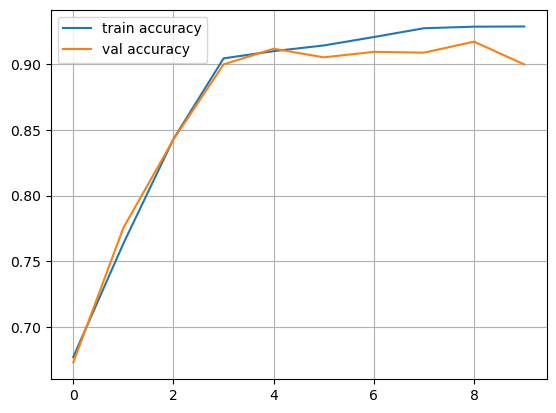

In [42]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

train_log = []
val_log = []

for epoch in range(10):
    for x_batch, y_batch in iterate_minibatches(
        X_train, y_train, batchsize=256, shuffle=True
    ):
        train(network, x_batch, y_batch)

    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))

    clear_output()
    print("Epoch", epoch)
    print("Train accuracy:", train_log[-1])
    print("Val accuracy:", val_log[-1])

plt.plot(train_log, label="train accuracy")
plt.plot(val_log, label="val accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()